In [1]:
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import os
from dotenv import load_dotenv
from torch import nn
import torch
import pickle
import torch.optim as optim
from torch.autograd import grad
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

load_dotenv()

def get_spike_intervals(spike_times, start_times, stop_times):
    spikes_in_intervals = {}

    # Convert start_times and stop_times to numpy arrays for faster operations
    start_times = np.array(start_times)
    stop_times = np.array(stop_times)

    print(start_times-stop_times)

    # Loop through each neuron, but optimize the spike finding with vectorized operations
    for neuron_id, times in spike_times.items():
        # Convert times to a numpy array if it's not already
        times = np.array(times)
        
        # Use numpy's searchsorted to find the indices where the start and stop times would fit
        start_indices = np.searchsorted(times, start_times, side='left')
        stop_indices = np.searchsorted(times, stop_times, side='right')
        
        # Get the number of spikes in each interval by subtracting indices
        spikes_in_intervals[neuron_id] = stop_indices - start_indices
    
    return spikes_in_intervals


# Sample LNP Model definition
class LNPModel(nn.Module):
    def __init__(self, input_dim, n_neurons):
        super(LNPModel, self).__init__()
        self.linear = nn.Linear(input_dim, 10)  # Linear layer for each neuron
        self.linear2=nn.Linear(10, n_neurons)
    
    def forward(self, x):
        x = self.linear(x)
        x=self.linear2(x)
        firing_rate = torch.exp(x)  # Exponential non-linearity
        return firing_rate

class FrontierPipeline:
    def __init__(self, session_id=831882777):
        output_dir=os.environ['ALLEN_NEUROPIXELS_PATH']
        manifest_path = os.path.join(output_dir, "manifest.json")
        self.cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
        self.session= self.cache.get_session_data(session_id)
        self.stimuli_df=self.session.stimulus_presentations
        embeddings=pickle.load(open('/home/maria/Documents/HuggingMouseData/TransformerEmbeddings/openai_clip-vit-base-patch32_embeddings.pkl','rb'))['natural_movie_one']
        self.embeddings=torch.tensor(embeddings, dtype=torch.float32)

    def training_loop(self, lnp_model, real_spikes_tensor, trial_index):
        # Training loop
        # Loss function (Negative Log-Likelihood) and Optimizer
        criterion = nn.PoissonNLLLoss(log_input=False)  # Poisson Negative Log-Likelihood Loss
        optimizer = optim.Adam(lnp_model.parameters(), lr=0.001, weight_decay=1e-2)
        num_epochs = 10000
        delta=0.0333
        for epoch in range(num_epochs):
            lnp_model.train()
            
            # Forward pass
            predicted_firing_rate = lnp_model(self.embeddings).squeeze()*delta
            
            # Compute loss
            loss = criterion(predicted_firing_rate, real_spikes_tensor)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print loss
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        print('Training finished')
        weights=lnp_model.linear2.weight.detach().numpy()
        return lnp_model, weights
    
    def __call__(self, trial_index, stimulus_type='natural_movie_one_more_repeats'):
        stim = self.stimuli_df[self.stimuli_df['stimulus_name'] == stimulus_type]
        spike_times=self.session.spike_times
        spike_times=get_spike_intervals(spike_times,stim['start_time'].values,stim['stop_time'].values)
        spikes=torch.tensor([spike_times[key] for key in spike_times.keys()],dtype=torch.float32)[:,trial_index*900:(trial_index+1)*900].T
        lnp=LNPModel(self.embeddings.shape[1], len(spike_times.keys()))
        lnp_model, weights=self.training_loop(lnp,spikes,trial_index)

        return lnp_model, weights, self.embeddings

/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipeline=FrontierPipeline()
for i in range(1):
    lnp_model, weights, embeddings=pipeline(i)

/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/maria/NeuroGarage/.venv/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


[-0.03336096 -0.03336096 -0.03336096 ... -0.0333607  -0.0333607
 -0.0333607 ]
Epoch [10/10000], Loss: 0.7523
Epoch [20/10000], Loss: 0.7319
Epoch [30/10000], Loss: 0.7053
Epoch [40/10000], Loss: 0.6709
Epoch [50/10000], Loss: 0.6295
Epoch [60/10000], Loss: 0.5849
Epoch [70/10000], Loss: 0.5416
Epoch [80/10000], Loss: 0.5023
Epoch [90/10000], Loss: 0.4689
Epoch [100/10000], Loss: 0.4412
Epoch [110/10000], Loss: 0.4193
Epoch [120/10000], Loss: 0.4035
Epoch [130/10000], Loss: 0.3925
Epoch [140/10000], Loss: 0.3850
Epoch [150/10000], Loss: 0.3804
Epoch [160/10000], Loss: 0.3778
Epoch [170/10000], Loss: 0.3760
Epoch [180/10000], Loss: 0.3746
Epoch [190/10000], Loss: 0.3736
Epoch [200/10000], Loss: 0.3729
Epoch [210/10000], Loss: 0.3723
Epoch [220/10000], Loss: 0.3719
Epoch [230/10000], Loss: 0.3715
Epoch [240/10000], Loss: 0.3712
Epoch [250/10000], Loss: 0.3710
Epoch [260/10000], Loss: 0.3709
Epoch [270/10000], Loss: 0.3707
Epoch [280/10000], Loss: 0.3706
Epoch [290/10000], Loss: 0.3704
Epo

In [41]:
def calculate_Fisher_matrix(lnp_model, weights, embeddings):
    firing_rate=lnp_model(embeddings)
    print(firing_rate.shape)
    delta=0.0333
    take_neuron_0=firing_rate[:,0].detach().numpy()*delta
    print(take_neuron_0.shape)
    #Shape 768x900
    emb_matrix=np.array(np.sum([embeddings[i].detach().numpy().reshape(-1,1)@embeddings[i].detach().numpy().reshape(1,-1) for i in range(embeddings.shape[0])]))
    print('emb', emb_matrix.shape, embeddings[i].detach().numpy().shape)
    #Shape 768x768-- embedding shape
    # Reshape take_neuron_0 to broadcast along the embedding matrix dimensions
    take_neuron_0 = take_neuron_0.reshape(-1, 1, 1)  # Shape (900, 1, 1)
    # Broadcast to create the scaled embedding matrix for each observation
    fisher_matrix = take_neuron_0 * emb_matrix  # Shape (900, 768, 768)
    
    # Sum across the 0 axis to get the Fisher information matrix
    fisher_matrix = fisher_matrix.sum(axis=0)  # Shape (768, 768)
    print(fisher_matrix.shape)  # Expected shape (768, 768)
    
    return fisher_matrix

fisher_mat=calculate_Fisher_matrix(lnp_model, weights, embeddings)

torch.Size([900, 657])
(900,)
emb () (768,)
(1, 1)


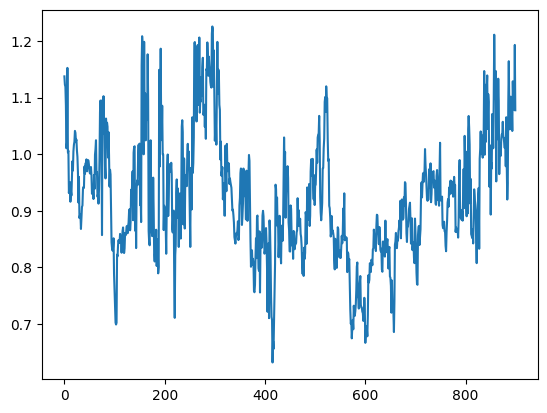

In [24]:
firing_rate=lnp_model(embeddings)

plt.plot(firing_rate[:,5].detach().numpy()*0.0333)

array([[ 175559.08 ,  -33034.2  ,  -69427.055, ..., -150790.61 ,
         -83411.59 ,    8923.429],
       [ -33034.2  , 2963195.2  , 1673984.4  , ...,  872260.8  ,
        1611708.9  , 1435821.5  ],
       [ -69427.055, 1673984.4  , 1144863.6  , ...,  658209.   ,
         974887.9  ,  862380.1  ],
       ...,
       [-150790.61 ,  872260.8  ,  658209.   , ...,  788467.9  ,
         619481.44 ,  530116.25 ],
       [ -83411.59 , 1611708.9  ,  974887.9  , ...,  619481.44 ,
        1015648.9  ,  810554.75 ],
       [   8923.429, 1435821.5  ,  862380.1  , ...,  530116.25 ,
         810554.75 ,  847222.06 ]], dtype=float32)

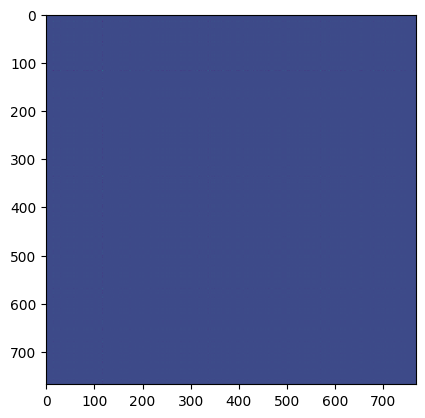

In [26]:
import matplotlib.pyplot as plt

plt.imshow(fisher_mat)
fisher_mat

In [22]:
weights

array([[-0.02684893,  0.02659404,  0.033979  , ...,  0.04344188,
         0.03805101,  0.03168983],
       [-0.02842571,  0.01778997,  0.02634878, ...,  0.0340428 ,
         0.02839522,  0.02630496],
       [-0.01602606,  0.01237073,  0.01495101, ...,  0.01840347,
         0.01471328,  0.0140758 ],
       ...,
       [ 0.01274966, -0.00864622, -0.01228298, ..., -0.01577893,
        -0.01320506, -0.01208503],
       [ 0.01275126, -0.00864773, -0.01228608, ..., -0.0158044 ,
        -0.01323322, -0.01208542],
       [ 0.01274455, -0.00864643, -0.01229237, ..., -0.01580756,
        -0.01320548, -0.01208637]], dtype=float32)

In [30]:
def calculate_Fisher_matrix(lnp_model, weights, embeddings):
    # Compute firing rates using the LNP model
    firing_rate = lnp_model(embeddings)
    print("Firing rate shape:", firing_rate.shape)

    # Scale factor if required (e.g., time window)
    delta = 0.0333
    scaled_firing_rate = firing_rate[:, 0].detach().numpy() *delta  # Select neuron 0
    print("Scaled firing rate shape:", scaled_firing_rate.shape)
    print("Scaled firing rate stats: min =", scaled_firing_rate.min(), "max =", scaled_firing_rate.max())

    # Compute embedding matrix (sum of outer products)
    emb_matrix = embeddings.detach().numpy().T @ embeddings.detach().numpy()
    print("Embedding matrix shape:", emb_matrix.shape)
    print("Embedding matrix stats: min =", emb_matrix.min(), "max =", emb_matrix.max(), "mean =", emb_matrix.mean())

    # Reshape scaled firing rate for broadcasting
    scaled_firing_rate = scaled_firing_rate.reshape(-1, 1, 1)  # Shape (900, 1, 1)

    # Create the Fisher information contributions for each observation
    fisher_matrix_contributions = scaled_firing_rate * emb_matrix  # Shape (900, 768, 768)

    # Sum across observations to get the final Fisher information matrix
    fisher_matrix = fisher_matrix_contributions.sum(axis=0)  # Shape (768, 768)
    print("Fisher information matrix shape:", fisher_matrix.shape)
    print("Fisher information matrix stats: min =", fisher_matrix.min(), "max =", fisher_matrix.max(), "mean =", fisher_matrix.mean())

    return fisher_matrix
calculate_Fisher_matrix(lnp_model, weights, embeddings)

Firing rate shape: torch.Size([900, 657])
Scaled firing rate shape: (900,)
Scaled firing rate stats: min = 0.9143953 max = 1.8642182
Embedding matrix shape: (768, 768)
Embedding matrix stats: min = -20586.57 max = 70915.38 mean = 35.12583
Fisher information matrix shape: (768, 768)
Fisher information matrix stats: min = -25228726.0 max = 86906370.0 mean = 43046.516


array([[ 175559.08 ,  -33034.2  ,  -69427.055, ..., -150790.61 ,
         -83411.59 ,    8923.429],
       [ -33034.2  , 2963195.2  , 1673984.4  , ...,  872260.8  ,
        1611708.9  , 1435821.5  ],
       [ -69427.055, 1673984.4  , 1144863.6  , ...,  658209.   ,
         974887.9  ,  862380.1  ],
       ...,
       [-150790.61 ,  872260.8  ,  658209.   , ...,  788467.9  ,
         619481.44 ,  530116.25 ],
       [ -83411.59 , 1611708.9  ,  974887.9  , ...,  619481.44 ,
        1015648.9  ,  810554.75 ],
       [   8923.429, 1435821.5  ,  862380.1  , ...,  530116.25 ,
         810554.75 ,  847222.06 ]], dtype=float32)

In [43]:
def calculate_Fisher_matrix(lnp_model, embeddings):
    # Compute firing rates using the LNP model
    firing_rate = lnp_model(embeddings)  # Shape: (n_observations, n_neurons)
    print("Firing rate shape:", firing_rate.shape)
    
    # Select the neuron of interest (e.g., neuron 0)
    take_neuron_0 = firing_rate[:, 0].detach().numpy()
    print("take_neuron_0 shape:", take_neuron_0.shape)
    print("take_neuron_0 stats: min =", take_neuron_0.min(), 
          "max =", take_neuron_0.max(), "mean =", take_neuron_0.mean())
    
    # Check if any firing rates are negative
    if np.any(take_neuron_0 < 0):
        raise ValueError("Negative firing rates detected. Check the LNP model output.")
    
    # Scaling factor (only apply if necessary)
    delta = 0.0333
    scaled_firing_rate = take_neuron_0 * delta
    print("Scaled firing rate stats: min =", scaled_firing_rate.min(), 
          "max =", scaled_firing_rate.max(), "mean =", scaled_firing_rate.mean())
    
    # Ensure scaled_firing_rate remains positive
    if np.any(scaled_firing_rate < 0):
        raise ValueError("Negative scaled firing rates detected after applying delta.")
    
    # Convert embeddings to NumPy array
    X = embeddings.detach().numpy()  # Shape: (n_observations, n_features)
    
    # Compute Fisher information matrix
    # I = sum_i (mu_i * X_i X_i^T)
    # To avoid large intermediate matrices, perform element-wise multiplication
    fisher_matrix = np.zeros((X.shape[1], X.shape[1]))
    for i in range(X.shape[0]):
        fisher_matrix += scaled_firing_rate[i] * np.outer(X[i], X[i])
    
    print("Fisher information matrix shape:", fisher_matrix.shape)
    print("Fisher information matrix stats: min =", fisher_matrix.min(), 
          "max =", fisher_matrix.max(), "mean =", fisher_matrix.mean())
    
    return fisher_matrix
calculate_Fisher_matrix(lnp_model, embeddings)

Firing rate shape: torch.Size([900, 657])
take_neuron_0 shape: (900,)
take_neuron_0 stats: min = 27.459316 max = 55.98253 mean = 40.890713
Scaled firing rate stats: min = 0.9143953 max = 1.8642182 mean = 1.3616606
Fisher information matrix shape: (768, 768)
Fisher information matrix stats: min = -27887.658660888672 max = 97564.17995071411 mean = 47.81137413166328


array([[ 189.69841765,  -69.71281632,  -91.61230654, ..., -171.03858804,
        -102.57448329,   -5.68035572],
       [ -69.71281632, 3348.09279573, 1902.16633799, ..., 1008.53806572,
        1801.78090174, 1606.83406722],
       [ -91.61230654, 1902.16633799, 1295.20909288, ...,  742.15015006,
        1090.29294241,  964.42175814],
       ...,
       [-171.03858804, 1008.53806572,  742.15015006, ...,  879.19670916,
         693.36614909,  596.031809  ],
       [-102.57448329, 1801.78090174, 1090.29294241, ...,  693.36614909,
        1116.57601628,  894.81990914],
       [  -5.68035572, 1606.83406722,  964.42175814, ...,  596.031809  ,
         894.81990914,  937.28555369]])

In [44]:
import numpy as np

def calculate_Fisher_matrix_corrected(lnp_model, embeddings, neuron_index=0, delta=0.0333):
    """
    Calculate the Fisher Information Matrix for a specified neuron in the LNP model.

    Parameters:
    - lnp_model: The Linear Nonlinear Poisson model.
    - embeddings: The input embeddings (numpy array or torch tensor).
    - neuron_index: Index of the neuron to calculate Fisher information for.
    - delta: Scaling factor (e.g., time window).

    Returns:
    - fisher_matrix: The Fisher Information Matrix (numpy array).
    """
    # Compute firing rates using the LNP model
    firing_rate = lnp_model(embeddings)  # Shape: (n_observations, n_neurons)
    print("Firing rate shape:", firing_rate.shape)
    
    # Select the neuron of interest
    take_neuron = firing_rate[:, neuron_index].detach().numpy()
    print(f"take_neuron_{neuron_index} shape:", take_neuron.shape)
    print(f"take_neuron_{neuron_index} stats: min =", take_neuron.min(), 
          "max =", take_neuron.max(), "mean =", take_neuron.mean())
    
    # Ensure firing rates are positive
    if np.any(take_neuron < 0):
        raise ValueError(f"Firing rates for neuron {neuron_index} contain negative values.")
    
    # Apply scaling if necessary
    scaled_firing_rate = take_neuron * delta
    print("Scaled firing rate stats: min =", scaled_firing_rate.min(), 
          "max =", scaled_firing_rate.max(), "mean =", scaled_firing_rate.mean())
    
    # Ensure scaled_firing_rate remains positive
    if np.any(scaled_firing_rate < 0):
        raise ValueError("Negative scaled firing rates detected after applying delta.")
    
    # Convert embeddings to NumPy array
    X = embeddings.detach().numpy()  # Shape: (n_observations, n_features)
    
    # Optional: Normalize embeddings to prevent large values
    # X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    # Initialize Fisher information matrix
    d = X.shape[1]
    fisher_matrix = np.zeros((d, d))
    
    # Compute Fisher information matrix using explicit summation
    for i in range(X.shape[0]):
        fisher_matrix += scaled_firing_rate[i] * np.outer(X[i], X[i])
        if (i + 1) % 100 == 0 or i == X.shape[0] - 1:
            print(f"Processed {i + 1}/{X.shape[0]} observations")
    
    print("Fisher information matrix shape:", fisher_matrix.shape)
    print("Fisher information matrix stats: min =", fisher_matrix.min(), 
          "max =", fisher_matrix.max(), "mean =", fisher_matrix.mean())
    
    # Check if Fisher matrix is positive semi-definite
    eigenvalues = np.linalg.eigvalsh(fisher_matrix)
    if np.any(eigenvalues < -1e-8):  # Allowing for small numerical errors
        print("Warning: Fisher information matrix has negative eigenvalues.")
    else:
        print("Fisher information matrix is positive semi-definite.")
    
    return fisher_matrix

calculate_Fisher_matrix_corrected(lnp_model, embeddings, neuron_index=0, delta=0.0333)


Firing rate shape: torch.Size([900, 657])
take_neuron_0 shape: (900,)
take_neuron_0 stats: min = 27.459316 max = 55.98253 mean = 40.890713
Scaled firing rate stats: min = 0.9143953 max = 1.8642182 mean = 1.3616606
Processed 100/900 observations
Processed 200/900 observations
Processed 300/900 observations
Processed 400/900 observations
Processed 500/900 observations
Processed 600/900 observations
Processed 700/900 observations
Processed 800/900 observations
Processed 900/900 observations
Fisher information matrix shape: (768, 768)
Fisher information matrix stats: min = -27887.658660888672 max = 97564.17995071411 mean = 47.81137413166328
Fisher information matrix is positive semi-definite.


array([[ 189.69841765,  -69.71281632,  -91.61230654, ..., -171.03858804,
        -102.57448329,   -5.68035572],
       [ -69.71281632, 3348.09279573, 1902.16633799, ..., 1008.53806572,
        1801.78090174, 1606.83406722],
       [ -91.61230654, 1902.16633799, 1295.20909288, ...,  742.15015006,
        1090.29294241,  964.42175814],
       ...,
       [-171.03858804, 1008.53806572,  742.15015006, ...,  879.19670916,
         693.36614909,  596.031809  ],
       [-102.57448329, 1801.78090174, 1090.29294241, ...,  693.36614909,
        1116.57601628,  894.81990914],
       [  -5.68035572, 1606.83406722,  964.42175814, ...,  596.031809  ,
         894.81990914,  937.28555369]])

In [46]:
import numpy as np

def calculate_Fisher_matrix_vectorized(lnp_model, embeddings, neuron_index=0, delta=0.0333):
    """
    Calculate the Fisher Information Matrix using vectorized operations.

    Parameters:
    - lnp_model: The Linear Nonlinear Poisson model.
    - embeddings: The input embeddings (torch tensor).
    - neuron_index: Index of the neuron to calculate Fisher information for.
    - delta: Scaling factor (e.g., time window).

    Returns:
    - fisher_matrix: The Fisher Information Matrix (numpy array).
    """
    # Compute firing rates using the LNP model
    firing_rate = lnp_model(embeddings)  # Shape: (n_observations, n_neurons)
    print("Firing rate shape:", firing_rate.shape)
    
    # Select the neuron of interest
    take_neuron = firing_rate[:, neuron_index].detach().numpy()
    print(f"take_neuron_{neuron_index} shape:", take_neuron.shape)
    print(f"take_neuron_{neuron_index} stats: min =", take_neuron.min(), 
          "max =", take_neuron.max(), "mean =", take_neuron.mean())
    
    # Ensure firing rates are positive
    if np.any(take_neuron < 0):
        raise ValueError(f"Firing rates for neuron {neuron_index} contain negative values.")
    
    # Apply scaling if necessary
    scaled_firing_rate = take_neuron * delta
    print("Scaled firing rate stats: min =", scaled_firing_rate.min(), 
          "max =", scaled_firing_rate.max(), "mean =", scaled_firing_rate.mean())
    
    # Ensure scaled_firing_rate remains positive
    if np.any(scaled_firing_rate < 0):
        raise ValueError("Negative scaled firing rates detected after applying delta.")
    
    # Convert embeddings to NumPy array
    X = embeddings.detach().numpy()  # Shape: (n_observations, n_features)
    
    # Compute scaled embeddings
    scaled_X = X * scaled_firing_rate[:, np.newaxis]  # Shape: (n_observations, n_features)
    
    # Compute Fisher information matrix
    fisher_matrix = scaled_X.T @ X  # Shape: (n_features, n_features)
    
    print("Fisher information matrix shape:", fisher_matrix.shape)
    print("Fisher information matrix stats: min =", fisher_matrix.min(), 
          "max =", fisher_matrix.max(), "mean =", fisher_matrix.mean())
    
    # Check if Fisher matrix is positive semi-definite
    eigenvalues = np.linalg.eigvalsh(fisher_matrix)
    if np.any(eigenvalues < -1e-8):  # Allowing for small numerical errors
        print("Warning: Fisher information matrix has negative eigenvalues.")
    else:
        print("Fisher information matrix is positive semi-definite.")
    
    return fisher_matrix

f=calculate_Fisher_matrix_vectorized(lnp_model, embeddings, neuron_index=0, delta=0.0333)


Firing rate shape: torch.Size([900, 657])
take_neuron_0 shape: (900,)
take_neuron_0 stats: min = 27.459316 max = 55.98253 mean = 40.890713
Scaled firing rate stats: min = 0.9143953 max = 1.8642182 mean = 1.3616606
Fisher information matrix shape: (768, 768)
Fisher information matrix stats: min = -27887.66 max = 97564.18 mean = 47.81138
Fisher information matrix is positive semi-definite.


(array([4.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 6.00000e+00, 1.60000e+01, 1.00000e+01, 1.80000e+01,
        3.20000e+01, 4.60000e+01, 6.00000e+01, 5.80000e+01, 1.32000e+02,
        1.70000e+02, 2.20000e+02, 3.98000e+02, 6.24000e+02, 1.76400e+03,
        8.73000e+03, 1.01142e+05, 4.34007e+05, 3.64190e+04, 4.51800e+03,
        8.23000e+02, 2.48000e+02, 1.32000e+02, 6.40000e+01, 5.30000e+01,
        3.20000e+01, 2.20000e+01, 1.20000e+01, 1.30000e+01, 1.20000e+01,
        1.00000e+01, 3.00000e+00, 0.00000e+00, 2.00000e+00, 4.00000e+00,
        0.00000e+00, 4.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

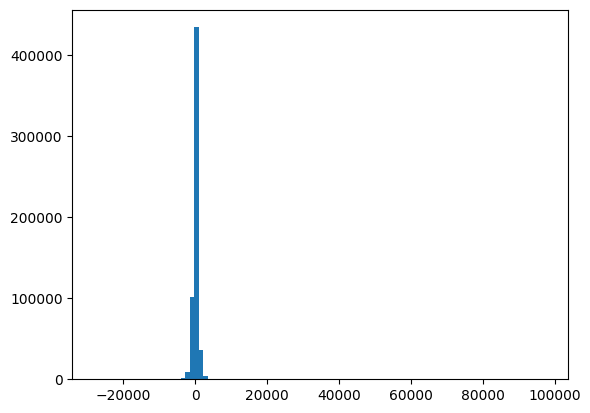

In [47]:
plt.hist(f.flatten(), bins=100)